# A Physics-Informed Neural Networks for System Identification
# Case Study: The Simple Pendulum


## Author (put your details)
 + Johanne Naa Ayeley Ekue
     + Researcher 
     + [Github Physics Project]https://github.com/johanne-ekue
     + Email: jnae.ekue@gmail.com
     
     


## Objectives (work on this)


+ Learn how to solve ODEs with neural networks using Physics.
+ See how the simulated neural network and physics based neural networks.
+ Introduce the problem of spectral bias in DNN's and see how we can solve it.

## References (put the papers you read here the same way)

+ [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations](https://arxiv.org/pdf/physics/9705023.pdf)
+ [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
+ [On the Spectral Bias of Neural Networks](http://proceedings.mlr.press/v97/rahaman19a/rahaman19a.pdf)
+ [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/pdf/2006.10739.pdf)


<b>copy this line and edit this for bold text</b>

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Phyics_Informed_ML"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

  !pip install -r requirements.txt
  !sudo apt-get autoremove


  from IPython.display import JSON
  from google.colab import output
  from subprocess import getoutput
  import os
  
  #@title jQuery Terminal's [Features](https://terminal.jcubic.pl/)

  def shell(command):
    if command.startswith('cd'):
      path = command.strip().split(maxsplit=1)[1]
      os.chdir(path)
      return JSON([''])
    return JSON([getoutput(command)])
  output.register_callback('shell', shell)

We're running Colab
Colab: mounting Google drive on  /content/drive
Mounted at /content/drive

Colab: making sure  /content/drive/My Drive/Colab Notebooks/Phyics_Informed_ML  exists.

Colab: Changing directory to  /content/drive/My Drive/Colab Notebooks/Phyics_Informed_ML
/content/drive/My Drive/Colab Notebooks/Phyics_Informed_ML
/content/drive/My Drive/Colab Notebooks/Phyics_Informed_ML
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libnvidia-common-510
0 upgraded, 0 newly installed, 1 to remove and 21 not upgraded.
After this operation, 35.8 kB disk space will be freed.
(Reading database ... 128126 files and directories currently installed.)
Removing libnvidia-common-510 (510.108.03-0ubuntu1) ...


In [2]:
# Change as you wish

if IN_COLAB:
  DATASET_FOLDER = './data/dataset/'
  DATA_FOLDER = './data/'
else:
  DATASET_FOLDER = './../data/dataset/'
  DATA_FOLDER = './../data/'

PMSM_DATA = 'pendulum_data.csv'


# myData = pd.read_csv(os.path.join(DATASET_FOLDER, PMSM_DATA))
# myData.round(decimals=6)
# myData=myData.astype(np.float32)
# myData=myData.astype(np.float16)
# myData.describe().transpose()

In [3]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

##Single order ODE
#Introduction
Physics informed neural network has received massive attention in the field of science and engineering. Physics Informed Neural Network(PINN) are neural networks(NN) that encodes model equations, like  Partial differential Equations(PDE), as a component of the neural network(Cuomo,s. et al(2022)).Using neural networks as surrogate models that have been trained using data gathered at a combination of input and output values is fundamentally different from PINNs. PINN has a wide range of potential applications in many fields due to its ability to incorporate physical constraints and laws into the training process of the neural network.Due to its simplicity, PINNs have helped advance several branches of computer science and engineering. PINNs are getting increased attention in the engineering and scientific literature for solving various differential equations with applications in weather modeling, healthcare, manufacturing, and other sectors.(lawal et al 2022).The intelligent and effective simulation and control of intricate real-world systems is becoming more and more crucial in the age of industry 4.0.PINN can also be used to solve problems such as strutural mechanics, fluid dynamics, heat transfer, climate modeling prediictive maintenance, financial modelling,space explorations,data assimilation, and optimization.The PINN approach essentially transforms the difficulty of directly solving the governing equations into a loss function optimization problem in order to identify ODE solutions.

PINNs consider the underlying ODE of our dynamic system (damped pendulum), i.e., the physics of the problem, rather than attempting to infer the solution purely from the data.According to Lagaris et al the best parameter values are determined using a neural network, and that the solution of a differential equation is stated as a constant term and an adjustable term with unknown parameters.
According to Cuomo,s. et al, physics inforned neural networks can address problems that are described by few data, or noisy experiment observations.
This introduces the era of digital twin:Performant and expressive computer simulations models able to seemlessly incorporate physical measurements.(Rosen et al.,2015).According to Mauel A. et al.data based modelling and physical models have limitations and to reduce model bias and bridge the gap  between both model types which includes physics informed neural network.

This paper focuses on using Ordinary Differential Equation(ODE) for our physics informed neural network to optimize our dynamical system (damped simple pendulum) to improve it numerically. The underlying physical laws governing the damped pendulum are incorporated into the architecture of the neural network by training the neural network to minimize the loss functions

#Methodology
The simulation of the damped pendulum of this paper was done by the use of ordinary differential equations.An ordinary differential equation (ODE) is a mathematical equation that relates an independent variable to a function of one variable and its derivatives. It is used to simulate a variety of natural phenomena, including as population expansion, electrical circuits, and chemical reactions. An ODE's solution reveals information on how, given the initial conditions described, the dependent variable changes over time.The order of the highest  differential cooefficient which is involved.When an equation is a polynomial in all the differential coefficient involved, the power to which the highest differential coefficient  is raised is known as the degree of the equation.Differential equations have been solved using a variety of techniques up to now. Some of them generate an array-based solution that contains the value of the solution at a chosen set of points.
Others transform the original and represent the result in analytical form using basis-functions.(legaris et al 1997).

ODE of the second order:

$$
\frac{d^2y}{dx^2} + y ={x^3}
$$
ODE of the first order:
$$
{(x +y)^2}\frac{dy}{dx}=1
$$
##Simple Pendulum
The dynamical system used as a case study for this paper is simple damped pendulum.The pendulum model is a classic model in physics and has important theoretical and practical significane(Jin Wang et al. 2022). A damped simple pendulum is an ideal case because of its deterministics behaviour due to its motion which is determined by its intial conditions and the laws of physics governing its  behavious,its complex behaviour which includes its oscillations, decay and eventually stopping which can be described mathematically using differential equations.The term "damping" refers to any impact that has the tendency to dissipate the system's energy through any kind of resistance. The ratio between damping force and relative velocity is represented by the damping coefficient.
A simple pendulum is an idealization of a real pendulum. It consists of an infinitely light rigid rod attached to a frictionless pivot point, and a point mass attached to the free end of rigid rod. 
##Ordinary differential equation
The Ode of the damped pendulum considered in the model is

$$
\dot{\omega} = (\frac{-b}{m})*ω + \frac{g}{l}sin\theta
$$
where:
$$
\dot{\omega} =\frac{d^2\theta}{dt^2}
$$

$$
{\omega} =\frac{d\theta}{dt}
$$
The b in the equation is the damping coeffiecient, m is the mass of the mass attached to the rod and the g is the acceleration due gravity,and l is the length of the inelastic string.

##Predicting Motion of The Pendulum Using Neural Network
Linear regression model is a model that can capture linear relationships between inputs and outputs.
Two codes was writen for the motion of the pendulum.Linear regression and neural network were used for the first instance with respect to ODE of the pendulum.The lineare regressiom model is a statiscal approach to model the relationship of our Θ and time for 2o seconds. We obtained a mean squared error which will be further dicussed in the results and analysis sector.The advantage of this method is that it might not work well for non linear relationships has its has a low capacity for capturing interactions between features.

##The Neural Network Model
A neural network model provides a more complex model that can captire non-linear relationships between inputs and outputs.It has high capacity for capturing complex interactions between features and can handle non-linear relationships.
The code written trained a linear regressision model 

The  code used to simulate the motion of the pendulum was used as a means of  building a neural network model to predict the motion of a damped pendulum. It starts by defining a sequential neural network model with several dense layers. The model takes the input with 3 features, and the output is 2-dimensional (the angle and angular velocity of the pendulum). The model is then compiled using mean squared error as the loss function and Adam optimizer with a specified learning rate and "amsgrad" setting. The model is trained using the X_train data for 1000 epochs with a batch size of 2 and a validation split of 1%. The model performance is evaluated using the mean squared error between the predicted and actual test values. The results of the model prediction are plotted and compared to the true values in several different plots to visually assess the performance of the model.
This method requires more data and computing resources to train and can be more difficult to optimize compared to a simple linear model.
Additionally, it might be prone to overfitting, which means that is memorizes the training data instead of leanring general patterns



#Physics Informed Neural Network
To illustrate the method used in this paper, consider the first ODE of the damped pendulum.
Consider the ode:
$$
\frac{d(\theta, ω)}{dt} = f((\theta,ω),t)
$$
with $x \in R^2 $ and initial conditions (IC):
$$
x(0) = [\theta_0,\omega_0]^T
$$
We write the trial solution by:
$$
[\hat{\theta_t},\hat{\omega_t}]^T = [\theta_0,\omega_0]^T +  N(\theta,\omega)*dt
$$
or
$$
[\hat{\theta_t},\hat{\omega_t}]^T = ode45([\theta_0,\omega_0]^T, N(\omega, \theta), \Delta_t)
$$
where $N(\omega, \theta)$ is a neural network (NN).

The solution $[\hat{\theta_t},\hat{\omega_t}]^T$ automatically satisfies the initial conditions.

The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d(\theta, ω)}{dt} - f(\hat{\theta},\hat{\omega},t)\right]^2dt
$$

$NB$ The trial solution using the neural network may not give the numeric accuracy of the system. 

#RK Integration Methods - Click to read more
https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html

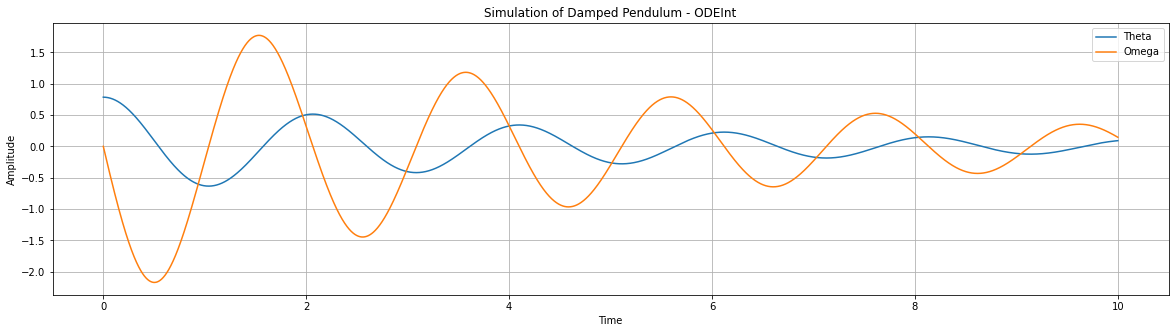

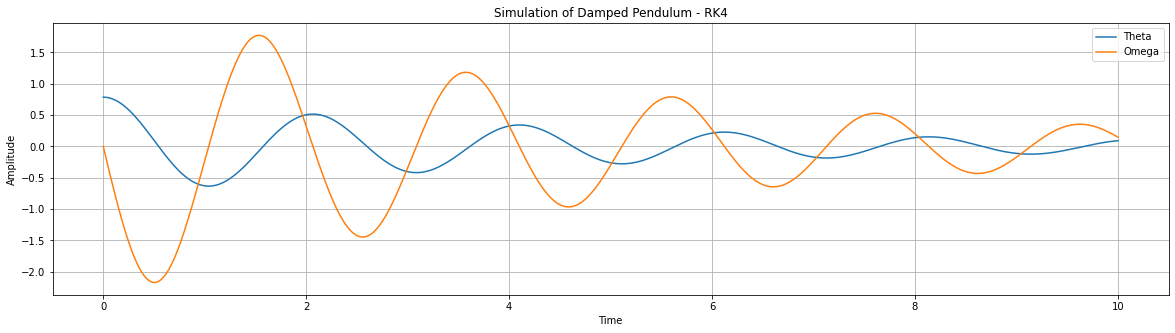

In [70]:
from scipy.integrate import odeint
import math
import torch
torch.manual_seed(0)
import torch.nn as nn
torch.autograd.set_detect_anomaly(True)
import numpy as np
np.random.seed(0)
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython.display import display, clear_output
import time
 

# Define the parameters of the system
m = 0.05   # mass of the pendulum
g = 9.81   # acceleration due to gravity
L = 1.0    # length of the pendulum
b = 0.02   # damping coefficient

# Define the time interval and time step
t0 = 0.0
tmax = 10
dt = 0.001

def rungekutta4_jit(f, y0, t, args=()):
  n = len(t)
  y = np.zeros((n, len(y0)))
  y[0] = y0
  for i in range(n - 1):
      h = t[i+1] - t[i]
      k1 = f(y[i], t[i], *args)
      k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
      k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
      k4 = f(y[i] + k3 * h, t[i] + h, *args)
      y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
  return y

def rungekutta4_step(x_Dot, x_prev, dt, args=()):
    k1 = x_Dot(x_prev, *args)
    k2 = x_Dot(x_prev + k1 * dt/2., *args)
    k3 = x_Dot(x_prev + k2 * dt/2., *args)
    k4 = x_Dot(x_prev + k3 * dt, *args)
    return x_prev + (dt / 6.) * (k1 + 2*k2 + 2*k3 + k4)

# The right-hand side function or first order ODE
def damp_Pen(x, t, b, g, L,m):
     theta=x[0]
     omega=x[1]
     theta_dot=omega
     omega_dot=-((b/m)*(omega))-((g/L)*math.sin(theta));
     x_dot=np.array([theta_dot,omega_dot])
     return x_dot

# Iniial conditions
x0 = [np.pi/4.0,0]

t = torch.linspace(0,tmax,int(tmax//dt))

# Solving the ODE
x = odeint(damp_Pen,x0,t,args=(b,g,l,m))
# x = rungekutta4_jit(damp_Pen,x0,t,args=(b,g,l,m))

# Plot the results
plt.figure(figsize=(20,5))
plt.plot(t, x[:,0],label='Theta')
plt.plot(t, x[:,1],label='Omega')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.grid(True)
plt.title('Simulation of Damped Pendulum - ODEInt')
plt.show()

# The right-hand side function or first order ODE
def damp_Pen(x, b, g, l,m):
     theta=x[0]
     omega=x[1]
     theta_dot=omega
     omega_dot=-((b/m)*(omega))-((g/l)*math.sin(theta));
     x_dot=np.array([theta_dot,omega_dot]).reshape(-1,1)
     return x_dot

# True solution
x_t = [np.array(x0).reshape(-1,1)]  

for idx in range(len(t)-1):
  x_t.append(rungekutta4_step(damp_Pen, x_t[idx], 1e-3, args=(b,g,l,m)))  # 
x_t = np.array(x_t).reshape(-1,2)

# Plot the results
plt.figure(figsize=(20,5))
plt.plot(t, x_t[:,0],label='Theta')
plt.plot(t, x_t[:,1],label='Omega')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.grid(True)
plt.title('Simulation of Damped Pendulum - RK4')
plt.show()



In [72]:
# Define the number of hidden layers and hidden units in the neural network
hidden_layers = 5
hidden_units = 50


class PINN(nn.Module):
    def __init__(self, dropout_prob=0.01):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, hidden_units)
        self.hidden = nn.ModuleList()
        for i in range(hidden_layers - 1):
            self.hidden.append(nn.Sequential(
                nn.Linear(hidden_units, hidden_units),
                nn.Mish(),
                nn.Dropout(p=dropout_prob)
            ))
        self.fc2 = nn.Linear(hidden_units, 2)
        self.dt = torch.tensor(dt, dtype=torch.float32)

    def forward(self, x):
        theta_prev, omega_prev = x[:, 0:1], x[:, 1:2]
        x = torch.tanh(self.fc1(x))
        for layer in self.hidden:
            x = layer(x)
        x = self.fc2(x)
        # x = self.f((x[:, 0:1], x[:, 1:2]))
        return x

    # def f(self, x):
    #     theta, omega = x
    #     return torch.cat([omega, -(b/m)*omega -(g/L)*torch.sin(theta)], dim=1)


# Define the loss function
def loss_function(omega_pred, omega_actual, omega_dot_pred, omega_dot_actual, residual_pred, residual_actual):
    loss = nn.MSELoss()(omega_pred, omega_actual)
    loss += nn.MSELoss()(omega_dot_pred, omega_dot_actual)
    loss += nn.MSELoss()(residual_pred, residual_actual)
    return loss

# Define the function that computes the residual of the differential equation
def residual_function(theta, omega, omega_dot):
    return omega_dot + (b/m)*omega + (g/L)*torch.sin(theta)

# Define the function for the derivative of theta and omega
def f(states):
    theta = states[:, 0].item()
    omega = states[:, 1].item()
    return torch.tensor([[omega, -(b/m)*omega -(g/L)*torch.sin(torch.tensor(theta))]], dtype=torch.float32)


In [74]:
# Initialize the PINN and the optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the initial conditions of the system
theta0 = torch.tensor([np.pi/4.0], dtype=torch.float32)  # Convert to tensor and specify data type
omega0 = torch.tensor([0.0], dtype=torch.float32)        # Convert to tensor and specify data type

# Define the data set
t = torch.arange(t0, tmax, dt, requires_grad=False)
theta = torch.zeros_like(t)
omega = torch.zeros_like(t)
omega_dot = torch.zeros_like(t)
theta_Pred = torch.zeros_like(t)
theta_dot_Pred = torch.zeros_like(t)
omega_Pred = torch.zeros_like(t)
omega_dot_Pred = torch.zeros_like(t)    
residual_actual = torch.zeros_like(t)
residual_Pred = torch.zeros_like(t)
Loss = torch.zeros_like(t)
theta[0] = theta0.item()
omega[0] = omega0.item()
theta_Pred[0] = theta0.item()
omega_Pred[0] = omega0.item()

In [78]:
num_epochs = 100

for epoch in tqdm(range(1,num_epochs+1)):

  # theta = np.zeros_like(t)
  # omega = np.zeros_like(t)
  # omega_dot = np.zeros_like(t)
  # theta_Pred = np.zeros_like(t)
  # theta_dot_Pred = np.zeros_like(t)
  # omega_Pred = np.zeros_like(t)
  # omega_dot_Pred = np.zeros_like(t)
  # Loss = np.zeros_like(t)
  # theta[0] = torch.randn(1).item()
  # omega[0] = torch.randn(1).item()
  # theta_Pred[0] = torch.randn(1).item()
  # omega_Pred[0] = torch.randn(1).item()

  for i in tqdm(range(1, len(t))):
      
      # Previous true and estimated solutions of the ODEs
      outputs_prev = torch.tensor( [[theta[i-1], omega[i-1]]],            dtype=torch.float32, requires_grad=True) 
      outputs_Prev = torch.tensor( [[theta_Pred[i-1], omega_Pred[i-1]]],  dtype=torch.float32, requires_grad=True)
      # outputs_Prev = outputs_prev

      # Use the 4th order Runge-Kutta method to compute the values of theta and omega at each time step
      k1 = torch.tensor( f(outputs_prev).detach().numpy(),          dtype=torch.float32)
      k2 = torch.tensor( f(outputs_prev+0.5*k1).detach().numpy(),   dtype=torch.float32)
      k3 = torch.tensor( f(outputs_prev+0.5*k2).detach().numpy(),   dtype=torch.float32)
      k4 = torch.tensor( f(outputs_prev+k3).detach().numpy(),       dtype=torch.float32)
      result = outputs_prev + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
      theta[i] = result[:,0]
      omega[i] = result[:,1]
      omega_dot[i] = k1[:,1]
      residual_actual[i] = residual_function(result[:,0], result[:,1], k1[:,1])

      optimizer.zero_grad()
      k1_ = model(outputs_Prev)
      k2_ = model(outputs_Prev+0.5*k1_)
      k3_ = model(outputs_Prev+0.5*k2_)
      k4_ = model(outputs_Prev+k3_)
      result_ = outputs_Prev + (dt/6)*(k1_ + 2*k2_ + 2*k3_ + k4_)
      theta_Pred[i] = result_[:,0]
      omega_Pred[i] = result_[:,1]
      omega_dot_Pred[i] = k1_[:,1]
      residual_Pred[i] = residual_function(result_[:,0], result_[:,1], k1_[:,1])

      loss = loss_function(torch.squeeze(k1_[:,0]), torch.squeeze(k1[:,0]), 
                           torch.squeeze(k1_[:,1]), torch.squeeze(k1[:,1]), 
                           torch.squeeze(torch.tensor(residual_Pred[i].clone().detach().numpy(), dtype=torch.float32)),
                           torch.squeeze(torch.tensor(residual_actual[i].clone().detach().numpy(), dtype=torch.float32)))
      loss.backward(retain_graph=True)
      # Loss[i] = loss
      optimizer.step()

      
      print("omega = {:.4f}, omega_pred = {:.4f}, omega_dot = {:.4f}, omega_dot_pred = {:.4f}, residual_actual = {:.4f}, residual_Pred = {:.4f}, loss = {:}".format(omega[i].item(), omega_Pred[i].item(), 
                                                                                                                                                                    omega_dot[i].item(), omega_dot_Pred[i].item(), 
                                                                                                                                                                    residual_actual[i].item(), residual_Pred[i].item(), 
                                                                                                                                                                    loss.item()))



  # Print the final state of the system
  # print("theta = {:.4f}, theta_pred = {:.4f}, omega = {:.4f}, omega_pred = {:.4f}, loss = {:}".format(theta[-1].item(), theta_Pred[-1].item(), omega[-1].item(), omega_Pred[-1].item(), loss.item()))
  # print("omega = {:.4f}, omega_pred = {:.4f}, omega_dot = {:.4f}, omega_dot_pred = {:.4f}, loss = {:}".format(Omega[-1].item(), omega_pred[-1].item(), Omega_dot[-1].item(), omega_dot_pred.item(), loss.item()))
  plt.figure(figsize=(20,5))
  plt.plot(t, theta.detach().numpy(), label='$\Theta$')
  plt.plot(t, theta_Pred.detach().numpy(), '--', label='$\Theta$_NN')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()
  plt.figure(figsize=(20,5))
  plt.plot(t, omega.detach().numpy(), label='$\Omega$')
  plt.plot(t, omega_Pred.detach().numpy(), '--', label='$\Omega$_NN')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()
  plt.figure(figsize=(20,5))
  plt.plot(t, omega_dot.detach().numpy(), label='$\Omega$_dot')
  plt.plot(t, omega_dot_Pred.detach().numpy(), '--', label='$\Omega$_dot_NN')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()
  plt.figure(figsize=(20,5))
  plt.plot(t, residual_actual.detach().numpy(), label='Residual_actual')
  plt.plot(t, residual_Pred.detach().numpy(), '--', label='Residual_pred')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

omega = 0.0009, omega_pred = -0.0059, omega_dot = -6.9367, omega_dot_pred = -6.4205, residual_actual = -0.0036, residual_Pred = 0.5148, loss = 0.5498150587081909
omega = 0.0018, omega_pred = -0.0118, omega_dot = -6.9331, omega_dot_pred = -6.4813, residual_actual = -0.0036, residual_Pred = 0.4526, loss = 0.42971837520599365
omega = 0.0027, omega_pred = -0.0178, omega_dot = -6.9296, omega_dot_pred = -6.7199, residual_actual = -0.0036, residual_Pred = 0.2121, loss = 0.09882114082574844
omega = 0.0036, omega_pred = -0.0237, omega_dot = -6.9260, omega_dot_pred = -6.0648, residual_actual = -0.0036, residual_Pred = 0.8652, loss = 1.5321359634399414
omega = 0.0045, omega_pred = -0.0299, omega_dot = -6.9224, omega_dot_pred = -7.0517, residual_actual = -0.0036, residual_Pred = -0.1236, loss = 0.03350381925702095
omega = 0.0054, omega_pred = -0.0361, omega_dot = -6.9189, omega_dot_pred = -7.0359, residual_actual = -0.0036, residual_Pred = -0.1098, loss = 0.02566860429942608
omega = 0.0064, omega_

KeyboardInterrupt: ignored

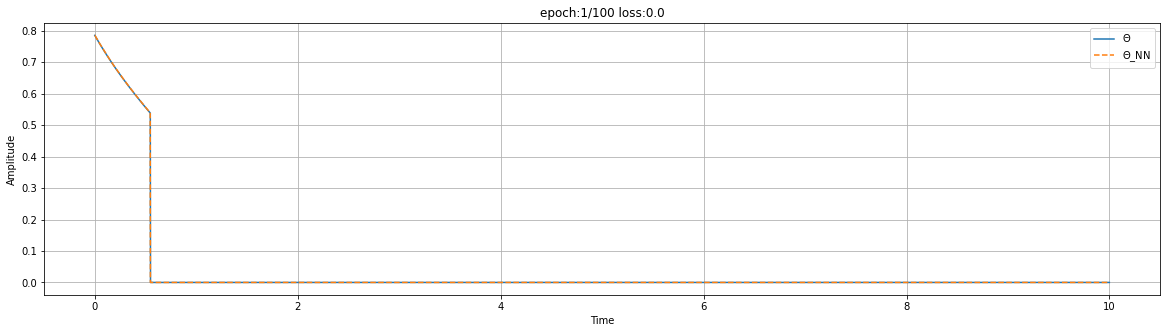

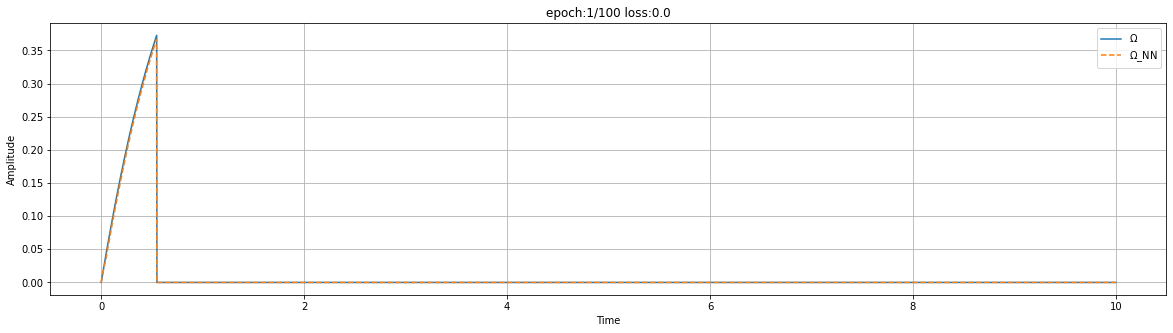

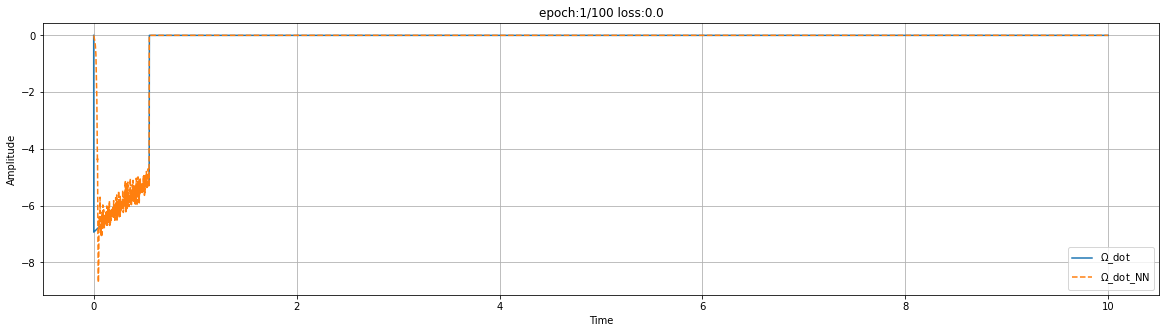

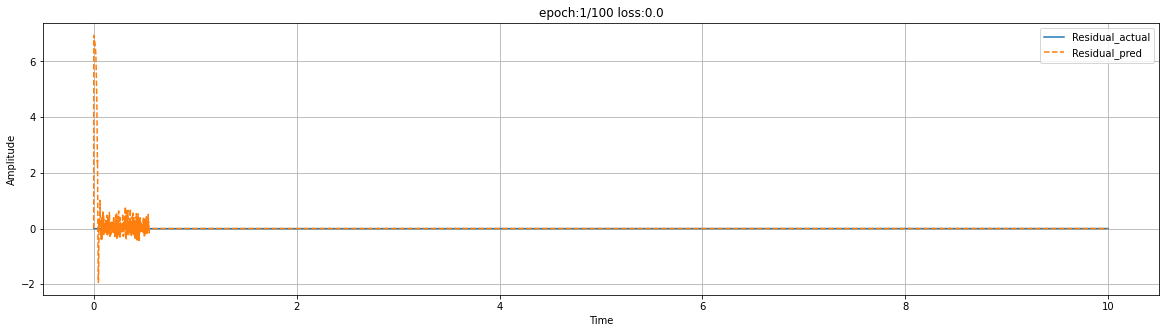

In [76]:
  plt.figure(figsize=(20,5))
  plt.plot(t, theta.detach().numpy(), label='$\Theta$')
  plt.plot(t, theta_Pred.detach().numpy(), '--', label='$\Theta$_NN')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()
  plt.figure(figsize=(20,5))
  plt.plot(t, omega.detach().numpy(), label='$\Omega$')
  plt.plot(t, omega_Pred.detach().numpy(), '--', label='$\Omega$_NN')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()
  plt.figure(figsize=(20,5))
  plt.plot(t, omega_dot.detach().numpy(), label='$\Omega$_dot')
  plt.plot(t, omega_dot_Pred.detach().numpy(), '--', label='$\Omega$_dot_NN')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()
  plt.figure(figsize=(20,5))
  plt.plot(t, residual_actual.detach().numpy(), label='Residual_actual')
  plt.plot(t, residual_Pred.detach().numpy(), '--', label='Residual_pred')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend(loc='best')
  plt.grid(True)
  plt.title(f'epoch:{epoch}/{num_epochs} loss:{Loss[i]}')
  plt.show()